<a href="https://colab.research.google.com/github/MohammedMusharraf11/ML_Project_915_344/blob/main/Chest_Xray_DeepLearning_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Disease Detection - Deep Learning (Google Colab + T4 GPU)

## Project Overview
**Goal:** Build a deep learning model to detect thoracic diseases from chest X-ray images

**Dataset:** NIH Chest X-ray Dataset (Sample)

**Target Diseases:**
1. Cardiomegaly (Enlarged heart)
2. Edema (Fluid accumulation in lungs)
3. Emphysema (Lung tissue damage)
4. Hernia (Organ displacement)
5. Pneumonia (Lung infection)
6. Fibrosis (Lung scarring)
7. Pneumothorax (Collapsed lung)

**Deep Learning Approach:**
- Transfer Learning with MobileNetV2 (lightweight, GPU-optimized)
- Multi-label classification (7 diseases)
- Data augmentation for better generalization

---

## Step 1: Mount Google Drive & Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully!")

Mounted at /content/drive
✅ Google Drive mounted successfully!


In [2]:
# Check GPU availability
import tensorflow as tf

print("="*70)
print("GPU CHECK")
print("="*70)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

if tf.config.list_physical_devices('GPU'):
    print("\n✅ GPU is available! Training will be FAST! 🚀")
    gpu = tf.config.list_physical_devices('GPU')[0]
    print(f"   GPU Device: {gpu}")
else:
    print("\n⚠️ No GPU found. Training will be slow.")
    print("   Go to Runtime > Change runtime type > Select T4 GPU")

print("\n" + "="*70)

GPU CHECK

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ GPU is available! Training will be FAST! 🚀
   GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



## Step 2: Import Libraries

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Metrics
from sklearn.metrics import roc_auc_score, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

# Utilities
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries imported successfully!")
print(f"   TensorFlow: {tf.__version__}")
print(f"   Keras: {keras.__version__}")

✅ All libraries imported successfully!
   TensorFlow: 2.19.0
   Keras: 3.10.0


## Step 3: Configure Paths & Load Dataset

In [4]:
# Configure paths
DATASET_PATH = "/content/drive/MyDrive/ML-Project/sample"
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
LABELS_CSV = os.path.join(DATASET_PATH, "sample_labels.csv")

print("="*70)
print("DATASET CONFIGURATION")
print("="*70)

# Verify paths exist
if os.path.exists(DATASET_PATH):
    print(f"\n✅ Dataset path found: {DATASET_PATH}")
else:
    print(f"\n❌ Dataset path not found: {DATASET_PATH}")
    print("   Please upload your dataset to Google Drive!")

if os.path.exists(IMAGES_PATH):
    image_count = len([f for f in os.listdir(IMAGES_PATH) if f.endswith('.png')])
    print(f"✅ Images folder found: {IMAGES_PATH}")
    print(f"   Total images: {image_count:,}")
else:
    print(f"❌ Images folder not found: {IMAGES_PATH}")

if os.path.exists(LABELS_CSV):
    print(f"✅ Labels CSV found: {LABELS_CSV}")
else:
    print(f"❌ Labels CSV not found: {LABELS_CSV}")

print("\n" + "="*70)

DATASET CONFIGURATION

✅ Dataset path found: /content/drive/MyDrive/ML-Project/sample
✅ Images folder found: /content/drive/MyDrive/ML-Project/sample/images
   Total images: 5,606
✅ Labels CSV found: /content/drive/MyDrive/ML-Project/sample/sample_labels.csv



In [5]:
# Load and prepare dataset
print("="*70)
print("LOADING DATASET")
print("="*70)

# Read CSV
df = pd.read_csv(LABELS_CSV)

print(f"\n📊 Dataset loaded: {len(df):,} images")
print(f"   Columns: {list(df.columns)}")

# Define target diseases
TARGET_DISEASES = ['Cardiomegaly', 'Edema', 'Emphysema', 'Hernia', 'Pneumonia', 'Fibrosis', 'Pneumothorax']

# Create binary labels
print(f"\n🎯 Creating binary labels for {len(TARGET_DISEASES)} diseases...")

for disease in TARGET_DISEASES:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in str(x) else 0)

print(f"   ✅ Binary labels created!")

# Show disease distribution
print(f"\n📈 Disease Distribution:")
print("-"*70)
for disease in TARGET_DISEASES:
    count = df[disease].sum()
    pct = (count / len(df)) * 100
    print(f"   {disease:20s}: {count:5d} ({pct:5.2f}%)")

# Add full image path
df['Image_Path'] = df['Image Index'].apply(lambda x: os.path.join(IMAGES_PATH, x))

# Verify images exist
existing_images = df['Image_Path'].apply(os.path.exists)
df = df[existing_images].reset_index(drop=True)

print(f"\n✅ Final dataset: {len(df):,} images with valid paths")
print("\n" + "="*70)

LOADING DATASET

📊 Dataset loaded: 5,606 images
   Columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y']

🎯 Creating binary labels for 7 diseases...
   ✅ Binary labels created!

📈 Disease Distribution:
----------------------------------------------------------------------
   Cardiomegaly        :   141 ( 2.52%)
   Edema               :   118 ( 2.10%)
   Emphysema           :   127 ( 2.27%)
   Hernia              :    13 ( 0.23%)
   Pneumonia           :    62 ( 1.11%)
   Fibrosis            :    84 ( 1.50%)
   Pneumothorax        :   271 ( 4.83%)

✅ Final dataset: 5,606 images with valid paths



## Step 4: Train-Validation-Test Split

In [6]:
print("="*70)
print("TRAIN-VALIDATION-TEST SPLIT")
print("="*70)

# Split: 70% train, 15% validation, 15% test
# First split: 70% train, 30% temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df['Pneumothorax']  # Most common disease
)

# Second split: 50% validation, 50% test (from temp)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['Pneumothorax']
)

print(f"\n📊 Split Summary:")
print(f"   Training:   {len(train_df):,} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"   Validation: {len(val_df):,} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"   Test:       {len(test_df):,} images ({len(test_df)/len(df)*100:.1f}%)")

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"\n✅ Split complete!")
print("\n" + "="*70)

TRAIN-VALIDATION-TEST SPLIT

📊 Split Summary:
   Training:   3,924 images (70.0%)
   Validation: 841 images (15.0%)
   Test:       841 images (15.0%)

✅ Split complete!



## Step 5: Create Data Generators with Augmentation

In [7]:
print("="*70)
print("CREATING DATA GENERATORS")
print("="*70)

# Image parameters
IMG_SIZE = 224  # MobileNetV2 input size
BATCH_SIZE = 32

print(f"\n📐 Image Configuration:")
print(f"   Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Color mode: RGB (3 channels)")

# Data augmentation for training (helps prevent overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

print(f"\n🔄 Data Augmentation (Training only):")
print(f"   Rotation: ±10°")
print(f"   Shift: ±10%")
print(f"   Zoom: ±10%")
print(f"   Horizontal flip: Yes")

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col=TARGET_DISEASES,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Image_Path',
    y_col=TARGET_DISEASES,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image_Path',
    y_col=TARGET_DISEASES,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

print(f"\n✅ Generators created successfully!")
print(f"   Training batches: {len(train_generator)}")
print(f"   Validation batches: {len(val_generator)}")
print(f"   Test batches: {len(test_generator)}")
print("\n" + "="*70)

CREATING DATA GENERATORS

📐 Image Configuration:
   Input size: 224x224
   Batch size: 32
   Color mode: RGB (3 channels)

🔄 Data Augmentation (Training only):
   Rotation: ±10°
   Shift: ±10%
   Zoom: ±10%
   Horizontal flip: Yes
Found 3924 validated image filenames.
Found 841 validated image filenames.
Found 841 validated image filenames.

✅ Generators created successfully!
   Training batches: 123
   Validation batches: 27
   Test batches: 27



## Step 6: Visualize Sample Images with Augmentation

Displaying sample images with augmentation...



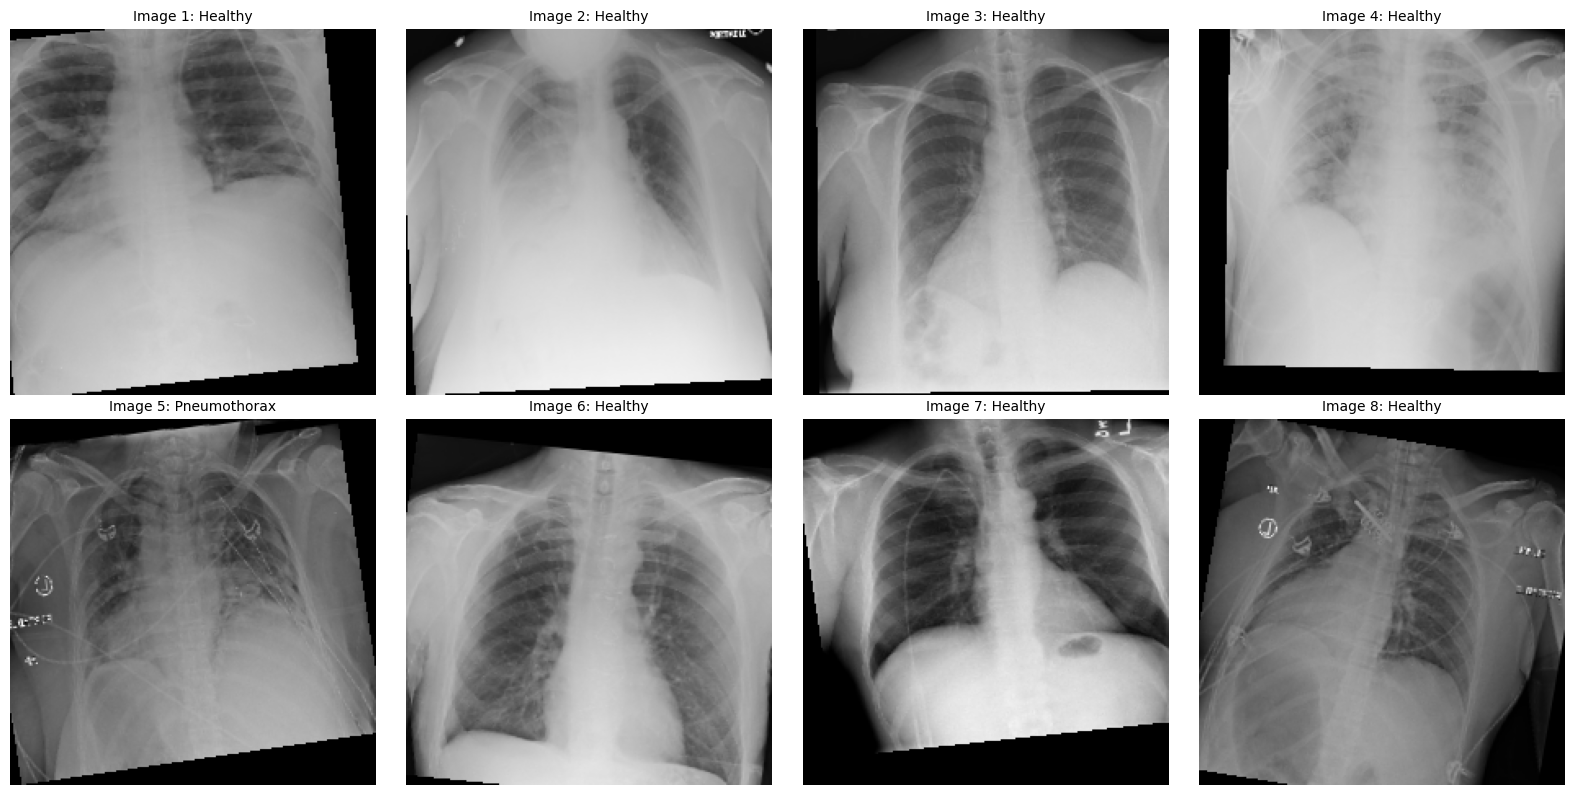

✅ Sample visualization complete!


In [8]:
# Visualize some augmented samples
print("Displaying sample images with augmentation...\n")

# Get one batch
sample_images, sample_labels = next(train_generator)

# Display first 8 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    ax.imshow(sample_images[i])

    # Get disease labels for this image
    diseases = [TARGET_DISEASES[j] for j in range(len(TARGET_DISEASES)) if sample_labels[i][j] == 1]
    if not diseases:
        diseases = ['Healthy']

    ax.set_title(f"Image {i+1}: {', '.join(diseases[:2])}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("✅ Sample visualization complete!")

## Step 7: Build CNN Model with Transfer Learning (MobileNetV2)

In [9]:
print("="*70)
print("BUILDING CNN MODEL - TRANSFER LEARNING")
print("="*70)

# Load pre-trained MobileNetV2 (trained on ImageNet)
print("\n🔧 Loading MobileNetV2 base model...")

base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze base model layers (we'll use pre-trained features)
base_model.trainable = False

print(f"   ✅ Base model loaded!")
print(f"   Total layers: {len(base_model.layers)}")
print(f"   Trainable: {base_model.trainable}")

# Build complete model
print("\n🏗️ Building custom classification head...")

model = models.Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(TARGET_DISEASES), activation='sigmoid')  # Multi-label: sigmoid
])

print("   ✅ Model architecture complete!")

# Compile model
print("\n⚙️ Compiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Multi-label classification
    metrics=[
        'accuracy',
        keras.metrics.AUC(name='auc', multi_label=True)
    ]
)

print("   ✅ Model compiled!")

# Model summary
print("\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)
model.summary()

print("\n" + "="*70)
print("✅ MODEL READY FOR TRAINING!")
print("="*70)

BUILDING CNN MODEL - TRANSFER LEARNING

🔧 Loading MobileNetV2 base model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   ✅ Base model loaded!
   Total layers: 155
   Trainable: False

🏗️ Building custom classification head...
   ✅ Model architecture complete!

⚙️ Compiling model...
   ✅ Model compiled!

MODEL SUMMARY


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


✅ MODEL READY FOR TRAINING!


## Step 8: Setup Training Callbacks

In [10]:
print("="*70)
print("SETTING UP TRAINING CALLBACKS")
print("="*70)

# Create models directory
MODEL_DIR = '/content/drive/MyDrive/ML-Project/models'
os.makedirs(MODEL_DIR, exist_ok=True)

# 1. Model Checkpoint - Save best model
checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, 'best_model_mobilenetv2.h5'),
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# 2. Early Stopping - Stop if no improvement
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 3. Reduce Learning Rate - Reduce LR when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]

print("\n✅ Callbacks configured:")
print("   1. ModelCheckpoint - Saves best model (val_auc)")
print("   2. EarlyStopping - Stops if no improvement for 5 epochs")
print("   3. ReduceLROnPlateau - Reduces LR if stuck for 3 epochs")
print(f"\n💾 Models will be saved to: {MODEL_DIR}")
print("\n" + "="*70)

SETTING UP TRAINING CALLBACKS

✅ Callbacks configured:
   1. ModelCheckpoint - Saves best model (val_auc)
   2. EarlyStopping - Stops if no improvement for 5 epochs
   3. ReduceLROnPlateau - Reduces LR if stuck for 3 epochs

💾 Models will be saved to: /content/drive/MyDrive/ML-Project/models



## Step 9: Train the Model 🚀

**Training will take approximately:**
- With T4 GPU: ~5-10 minutes per epoch
- Expected: 10-20 epochs total
- Total time: ~1-2 hours

In [11]:
print("="*70)
print("🚀 STARTING MODEL TRAINING")
print("="*70)

EPOCHS = 20

print(f"\n⏱️  Training Configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Training samples: {len(train_df):,}")
print(f"   Validation samples: {len(val_df):,}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Steps per epoch: {len(train_generator)}")
print(f"\n🎯 This will take approximately 1-2 hours on T4 GPU...\n")

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)

🚀 STARTING MODEL TRAINING

⏱️  Training Configuration:
   Epochs: 20
   Training samples: 3,924
   Validation samples: 841
   Batch size: 32
   Steps per epoch: 123

🎯 This will take approximately 1-2 hours on T4 GPU...

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.2343 - auc: 0.5011 - loss: 0.1622 
Epoch 1: val_auc improved from -inf to 0.67728, saving model to /content/drive/MyDrive/ML-Project/models/best_model_mobilenetv2.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 1967s 16s/step - accuracy: 0.2340 - auc: 0.5014 - loss: 0.1619 - val_accuracy: 0.0476 - val_auc: 0.6773 - val_loss: 0.0963 - learning_rate: 0.0010
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.1962 - auc: 0.6301 - loss: 0.1034
Epoch 2: val_auc improved from 0.67728 to 0.71271, saving model to /content/drive/MyDrive/ML-Project/models/best_model_mobilenetv2.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.1961 - auc: 0.6301 - loss: 0.1034 - val_accuracy: 0.0464 - val_auc: 0.7127 - val_loss: 0.0972 - learning_rate: 0.0010
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.2030 - auc: 0.6499 - loss: 0.0954
Epoch 3: val_auc improved from 0.71271 to 0.71548, saving model to /content/drive/MyDrive/ML-Project/models/best_model_mobilenetv2.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2030 - auc: 0.6499 - loss: 0.0954 - val_accuracy: 0.1189 - val_auc: 0.7155 - val_loss: 0.0929 - learning_rate: 0.0010
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.2294 - auc: 0.6141 - loss: 0.0947
Epoch 4: val_auc did not improve from 0.71548
123/123 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2293 - auc: 0.6142 - loss: 0.0948 - val_accuracy: 0.0832 - val_auc: 0.6961 - val_loss: 0.0944 - learning_rate: 0.0010
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.2311 - auc: 0.6640 - loss: 0.0955
Epoch 5: val_auc did not improve from 0.71548
123/123 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.2312 - auc: 0.6639 - loss: 0.0955 - val_accuracy: 0.0916 - val_auc: 0.6683 - val_loss: 0.0957 - learning_rate: 0.0010
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.1850 - auc: 0.6666 - loss: 0.0980
Epoch 6: val_auc did not improve from 0.71548

Epoch 6: ReduceLROnPlateau reduci

## Step 10: Plot Training History

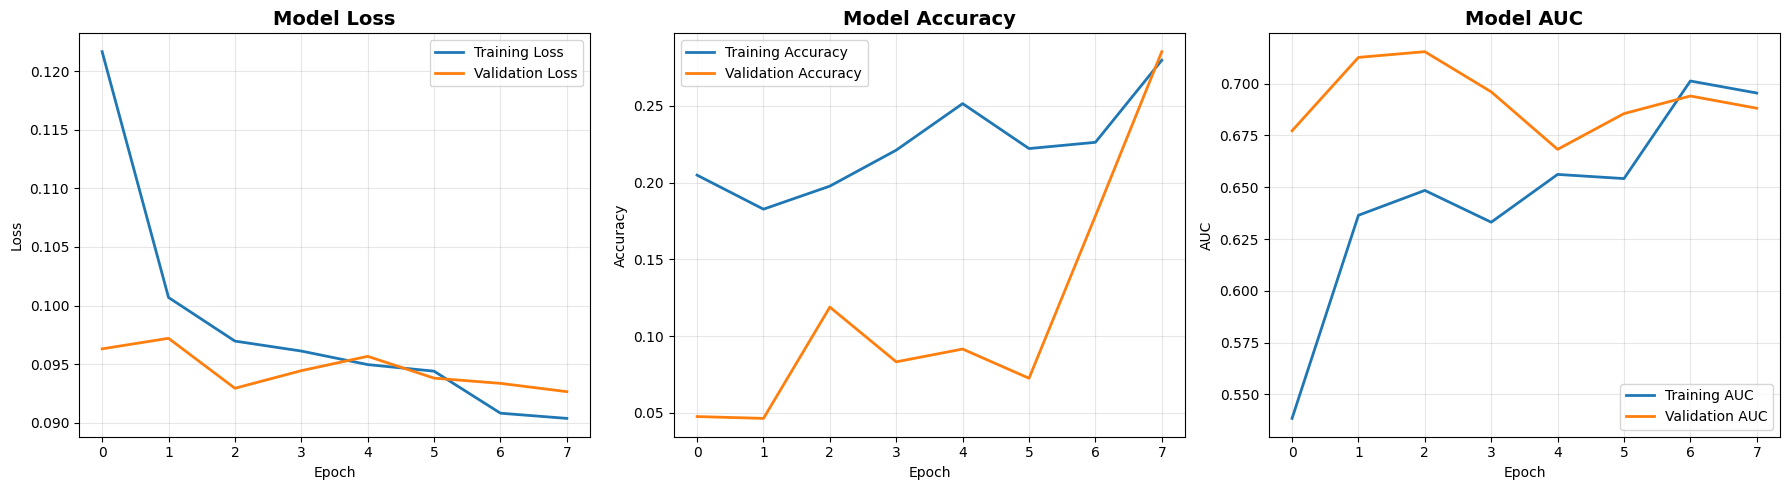

✅ Training curves saved!


In [12]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: AUC
axes[2].plot(history.history['auc'], label='Training AUC', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved!")

## Step 11: Evaluate on Test Set

In [13]:
print("="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Load best model
print("\n📂 Loading best model...")
best_model = keras.models.load_model(os.path.join(MODEL_DIR, 'best_model_mobilenetv2.h5'))
print("   ✅ Best model loaded!")

# Evaluate
print("\n🎯 Evaluating on test set...")
test_loss, test_acc, test_auc = best_model.evaluate(test_generator, verbose=1)

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test AUC: {test_auc:.4f}")
print("\n" + "="*70)

EVALUATING ON TEST SET

📂 Loading best model...


   ✅ Best model loaded!

🎯 Evaluating on test set...
27/27 ━━━━━━━━━━━━━━━━━━━━ 353s 13s/step - accuracy: 0.1087 - auc: 0.5877 - loss: 0.0934

TEST SET RESULTS
   Test Loss: 0.0934
   Test Accuracy: 0.0975
   Test AUC: 0.6052



## Step 12: Detailed Per-Disease Performance

In [14]:
print("="*70)
print("PER-DISEASE PERFORMANCE ANALYSIS")
print("="*70)

# Get predictions
print("\n🔮 Generating predictions...")
y_pred_proba = best_model.predict(test_generator, verbose=1)
y_true = test_df[TARGET_DISEASES].values

# Calculate AUC for each disease
print("\n📊 Per-Disease ROC-AUC Scores:")
print("="*70)
print(f"{'Disease':<20} {'ROC-AUC':>10} {'Positive Cases':>15}")
print("-"*70)

disease_aucs = []
for i, disease in enumerate(TARGET_DISEASES):
    auc = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
    disease_aucs.append(auc)
    pos_cases = y_true[:, i].sum()
    print(f"{disease:<20} {auc:>10.4f} {int(pos_cases):>15}")

avg_auc = np.mean(disease_aucs)
print("-"*70)
print(f"{'AVERAGE':<20} {avg_auc:>10.4f}")
print("="*70)

# Best and worst
best_idx = np.argmax(disease_aucs)
worst_idx = np.argmin(disease_aucs)

print(f"\n🏆 Best:  {TARGET_DISEASES[best_idx]} (AUC: {disease_aucs[best_idx]:.4f})")
print(f"😞 Worst: {TARGET_DISEASES[worst_idx]} (AUC: {disease_aucs[worst_idx]:.4f})")

# Save results
results_df = pd.DataFrame({
    'Disease': TARGET_DISEASES,
    'ROC-AUC': disease_aucs,
    'Positive_Cases': [y_true[:, i].sum() for i in range(len(TARGET_DISEASES))]
})

results_df.to_csv(os.path.join(MODEL_DIR, 'test_results.csv'), index=False)
print(f"\n💾 Results saved to: {MODEL_DIR}/test_results.csv")
print("\n" + "="*70)

PER-DISEASE PERFORMANCE ANALYSIS

🔮 Generating predictions...
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 729ms/step

📊 Per-Disease ROC-AUC Scores:
Disease                 ROC-AUC  Positive Cases
----------------------------------------------------------------------
Cardiomegaly             0.6295              24
Edema                    0.7726              19
Emphysema                0.7583              17
Hernia                   0.6752               2
Pneumonia                0.4882               9
Fibrosis                 0.4674              12
Pneumothorax             0.7301              40
----------------------------------------------------------------------
AVERAGE                  0.6459

🏆 Best:  Edema (AUC: 0.7726)
😞 Worst: Fibrosis (AUC: 0.4674)

💾 Results saved to: /content/drive/MyDrive/ML-Project/models/test_results.csv



## Step 13: Visualize Results

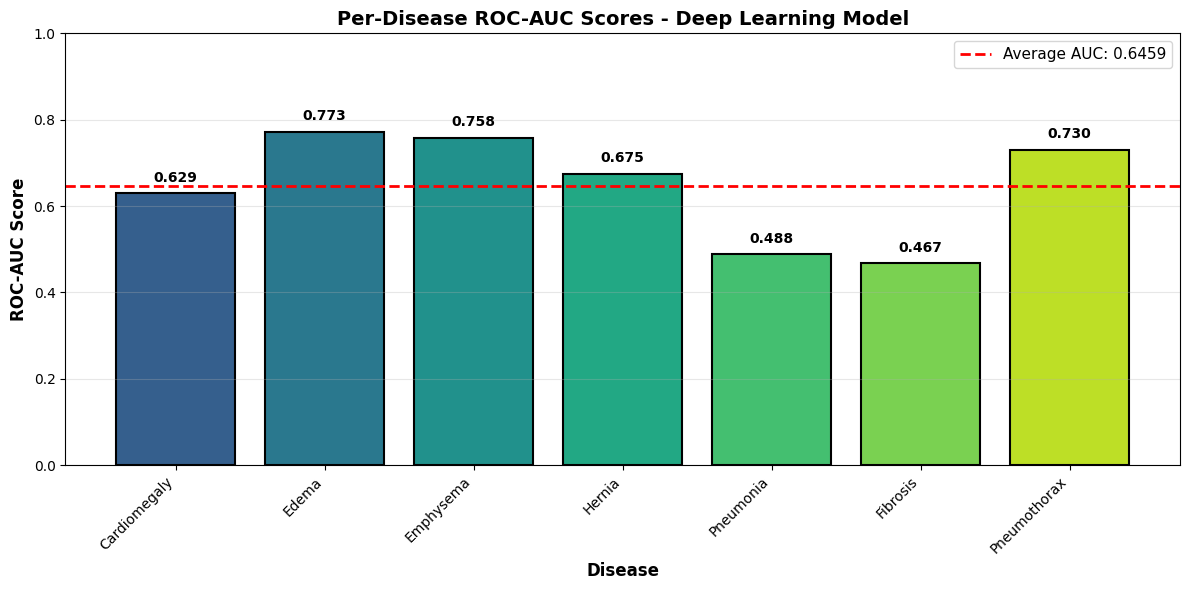

✅ Visualization saved!


In [15]:
# Create visualization of results
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(TARGET_DISEASES)))
bars = ax.bar(TARGET_DISEASES, disease_aucs, color=colors, edgecolor='black', linewidth=1.5)

# Add average line
ax.axhline(y=avg_auc, color='red', linestyle='--', linewidth=2, label=f'Average AUC: {avg_auc:.4f}')

# Customize plot
ax.set_xlabel('Disease', fontsize=12, fontweight='bold')
ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Disease ROC-AUC Scores - Deep Learning Model', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, auc in zip(bars, disease_aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{auc:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'disease_auc_scores.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved!")

## Step 14: Save Final Summary

In [16]:
# Create comprehensive summary
summary = f"""
{'='*70}
CHEST X-RAY DISEASE DETECTION - DEEP LEARNING RESULTS
{'='*70}

MODEL ARCHITECTURE:
  Base Model: MobileNetV2 (Transfer Learning)
  Input Size: {IMG_SIZE}x{IMG_SIZE}x3
  Classification Head: Dense(256) + Dropout(0.3) + Dense(7, sigmoid)
  Total Parameters: {best_model.count_params():,}

DATASET:
  Total Images: {len(df):,}
  Training: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)
  Validation: {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)
  Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)

TRAINING:
  Epochs Trained: {len(history.history['loss'])}
  Batch Size: {BATCH_SIZE}
  Optimizer: Adam (lr=0.001)
  Loss: Binary Crossentropy
  Data Augmentation: Yes

TEST SET PERFORMANCE:
  Overall Test Loss: {test_loss:.4f}
  Overall Test Accuracy: {test_acc:.4f}
  Overall Test AUC: {test_auc:.4f}

PER-DISEASE ROC-AUC SCORES:
{'-'*70}
"""

for disease, auc in zip(TARGET_DISEASES, disease_aucs):
    summary += f"  {disease:<20}: {auc:.4f}\n"

summary += f"""{'-'*70}
  AVERAGE AUC: {avg_auc:.4f}

BEST PERFORMING: {TARGET_DISEASES[best_idx]} (AUC: {disease_aucs[best_idx]:.4f})
WORST PERFORMING: {TARGET_DISEASES[worst_idx]} (AUC: {disease_aucs[worst_idx]:.4f})

{'='*70}
✅ MODEL TRAINING AND EVALUATION COMPLETE!
{'='*70}
"""

print(summary)

# Save summary to file
with open(os.path.join(MODEL_DIR, 'training_summary.txt'), 'w') as f:
    f.write(summary)

print(f"\n💾 Summary saved to: {MODEL_DIR}/training_summary.txt")
print("\n🎉 All done! Check your Google Drive for saved models and results!")


CHEST X-RAY DISEASE DETECTION - DEEP LEARNING RESULTS

MODEL ARCHITECTURE:
  Base Model: MobileNetV2 (Transfer Learning)
  Input Size: 224x224x3
  Classification Head: Dense(256) + Dropout(0.3) + Dense(7, sigmoid)
  Total Parameters: 2,587,719

DATASET:
  Total Images: 5,606
  Training: 3,924 (70.0%)
  Validation: 841 (15.0%)
  Test: 841 (15.0%)

TRAINING:
  Epochs Trained: 8
  Batch Size: 32
  Optimizer: Adam (lr=0.001)
  Loss: Binary Crossentropy
  Data Augmentation: Yes

TEST SET PERFORMANCE:
  Overall Test Loss: 0.0934
  Overall Test Accuracy: 0.0975
  Overall Test AUC: 0.6052

PER-DISEASE ROC-AUC SCORES:
----------------------------------------------------------------------
  Cardiomegaly        : 0.6295
  Edema               : 0.7726
  Emphysema           : 0.7583
  Hernia              : 0.6752
  Pneumonia           : 0.4882
  Fibrosis            : 0.4674
  Pneumothorax        : 0.7301
----------------------------------------------------------------------
  AVERAGE AUC: 0.6459

